In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

from typing import Optional, Union
import pandas as pd, numpy as np, torch
from datasets import Dataset
from dataclasses import dataclass
from transformers import AutoTokenizer
from transformers import EarlyStoppingCallback
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer

# **DATA LOADING** 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

data = pd.read_csv('/kaggle/input/llm-scientific-qa-with-openbook/LLm_Scientific_QA_with_OpenBook.csv')
# data = data.head(100)

df_train, df_temp = train_test_split(data, test_size=0.2, random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.6, random_state=42)

## Data Understading

In [17]:
print( 'prompt' , data[data['is_question']]['prompt'].iloc[0])
print('-'*116)
print( 'context' ,data[data['is_question']]['context'].iloc[0])

prompt Poison causes harm to which of the following?
--------------------------------------------------------------------------------------------------------------------
context In biology, a poison is a chemical substance causing death, injury or harm to organisms or their parts. A poison is any chemical substance that is harmful or lethal to living organisms. Whether something is considered a poison or not may depend on the amount, the circumstances, and what living things are present. In biology, poisons are substances that can cause death, injury, or harm to organs, tissues, cells, and DNA usually by chemical reactions or other activity on the molecular scale, when an organism is exposed to a sufficient quantity."Poison" at Merriam-Webster. The law defines "poison" more strictly. In ecological terms, poisons introduced into the environment can later cause unwanted effects elsewhere, or in other parts of the food chain. ==Modern definitions== In broad metaphorical (colloquial) usage

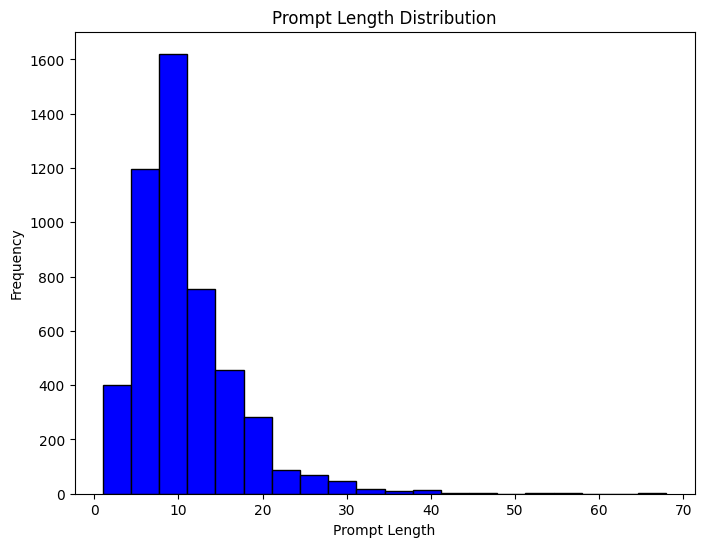

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(data['prompt'].apply(lambda x: len(x.split())), bins=20, color='blue', edgecolor='black')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')
plt.title('Prompt Length Distribution')
plt.show()

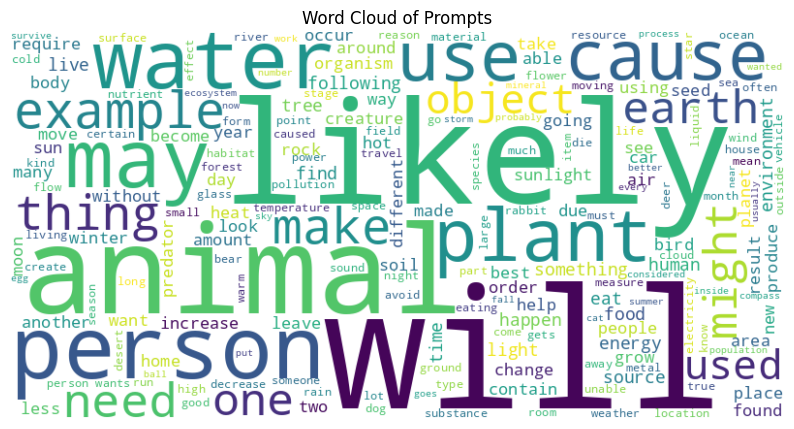

In [19]:
from wordcloud import WordCloud

# Combine all prompts into a single text
all_prompts_text = ' '.join(data['prompt'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_prompts_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Prompts')
plt.show()

## RAG
### "Knowledge-Enhanced Contextual Embedding" or "Contextual Information Retrieval"

In [21]:
!pip install sentence-transformers
!pip install faiss-cpu
!pip install blingfire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 44.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 35.3 MB/s eta 0:00:00:00:0100:01


In [27]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import pandas as pd
import faiss
from faiss import write_index, read_index

from tqdm import tqdm
import gc

from transformers import AutoTokenizer, AutoModel

from sentence_transformers import SentenceTransformer

In [22]:
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 32

In [23]:
data['answer_all'] = data.apply(lambda x: " ".join([x['A'], x['B'], x['C'], x['D']]), axis=1)
data['prompt_answer'] = data['prompt'] + " " + data['answer_all']

In [25]:
data.head(2)

,id,prompt,context,A,B,C,D,answer,is_question,answer_all,prompt_answer
0,7-980,The sun is responsible for,"Heterotrophs, such as animals, use light from ...",puppies learning new tricks,children growing up and getting old,flowers wilting in a vase,"plants sprouting, blooming and wilting",D,False,puppies learning new tricks children growing u...,The sun is responsible for puppies learning ne...
1,7-584,When standing miles away from Mount Rushmore,"However, Mount Rushmore also provides access t...",the mountains seem very close,the mountains are boring,the mountains look the same as from up close,the mountains seem smaller than in photographs,D,False,the mountains seem very close the mountains ar...,When standing miles away from Mount Rushmore t...


In [28]:
WIKI_PATH = '/kaggle/input/wikipedia-20230701'
sentence_index = read_index("/kaggle/input/wikipedia-2023-07-faiss-index/wikipedia_202307.index")

In [29]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
model.max_seq_length = MAX_LENGTH
model = model.half() #reduce memory usage and possibly increase computation speed

# Ensure data.prompt.values is correctly formatted as a list if necessary
prompts = data['prompt'].values.tolist()

# Use the encode method from SentenceTransformer
prompt_embeddings = model.encode(data.prompt.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
prompt_embeddings = prompt_embeddings.detach().cpu().numpy()
_ = gc.collect()

search_score, search_index = sentence_index.search(prompt_embeddings, 5)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

In [32]:
# search_score
search_index

array([[5438882, 5441831, 5669551,  540293, 5441812],
       [4973677, 3640392, 3649117, 1100718, 3640388],
       [5404171, 1850415, 3301837, 2130464, 1850172],
       ...,
       [ 301450, 4651732, 1589847, 1589845, 1502665],
       [5854204,  614710,  614661, 3102685,  614748],
       [3721108, 5352052, 1323865, 5579214, 4674481]])

In [34]:
import ctypes
libc = ctypes.CDLL("libc.so.6")
## Save memory - delete sentence_index since it is no longer necessary
del sentence_index
del prompt_embeddings
_ = gc.collect()
libc.malloc_trim(0)

1

In [35]:
# Load Wikipedia index data
df = pd.read_parquet(f"{WIKI_PATH}/wiki_2023_index.parquet", columns=['id', 'file'])

# Prepare data from the relevant Wikipedia articles
wikipedia_file_data = []
for i, (_, idx) in tqdm(enumerate(zip(search_score, search_index)), total=len(search_score)):
    _df = df.loc[idx].copy()
    _df['prompt_id'] = i
    wikipedia_file_data.append(_df)

wikipedia_file_data = pd.concat(wikipedia_file_data).reset_index(drop=True)
wikipedia_file_data = wikipedia_file_data[['id', 'prompt_id', 'file']].drop_duplicates().sort_values(['file', 'id']).reset_index(drop=True)

# Free memory
del df
gc.collect()
libc.malloc_trim(0)

100%|██████████| 4957/4957 [00:03<00:00, 1505.13it/s]


1

In [37]:
wikipedia_file_data

,id,prompt_id,file
0,1004186,793,a.parquet
1,10081120,1385,a.parquet
2,10081120,4646,a.parquet
3,10086576,1255,a.parquet
4,10140470,4205,a.parquet
...,...,...,...
24780,70462926,4793,z.parquet
24781,726413,4322,z.parquet
24782,9096372,1841,z.parquet
24783,913404,14,z.parquet


In [38]:
# Get the full text data
wiki_text_data = []

for file in tqdm(wikipedia_file_data.file.unique(), total=len(wikipedia_file_data.file.unique())):
    _id = [str(i) for i in wikipedia_file_data[wikipedia_file_data['file']==file]['id'].tolist()]
    _df = pd.read_parquet(f"{WIKI_PATH}/{file}", columns=['id', 'text'])

    _df_temp = _df[_df['id'].isin(_id)].copy()
    del _df
    _ = gc.collect()
    libc.malloc_trim(0)
    wiki_text_data.append(_df_temp)
wiki_text_data = pd.concat(wiki_text_data).drop_duplicates().reset_index(drop=True)
_ = gc.collect()

100%|██████████| 28/28 [04:58<00:00, 10.65s/it]


In [39]:
wiki_text_data

,id,text
0,69265876,A Beautiful Revolution Pt. 1 is the thirteenth...
1,69264718,A Beautiful Revolution Pt. 2 is the fourteenth...
2,18203711,A Big Fix: Radical Solutions for Australia's E...
3,12666064,"A Bird in the House, first published in 1970, ..."
4,67655971,A Call for American Renewal is an American pol...
...,...,...
14256,67361886,A Zoom town is a community that experiences a ...
14257,50558,Zooplankton are the animal component of the pl...
14258,45691558,Zoosystematics and Evolution is a peer-reviewe...
14259,11516911,Zootope is the total habitat available for col...


In [40]:
wiki_text_data['text'][0]

'A Beautiful Revolution Pt. 1 is the thirteenth studio album by American rapper Common. It was released on October 30, 2020 through Loma Vista Recordings, making it his second project released for the label. Production was handled by Karriem Riggins, Burniss Travis and Robert Glasper. It features guest appearances from PJ, Black Thought, Chuck D, Jessica Care Moore, Lenny Kravitz, Morgan Parker and Stevie Wonder. == Critical reception == === Accolades === Accolades for A Beautiful Revolution Pt. 1 Publication Accolade Rank Albumism The 100 Best Albums of 2020 == Track listing == == Charts == Chart (2021) Peak position US Current Album Sales (Billboard) 94 == References == == External links == * Category:2020 albums Category:Common (rapper) albums Category:Loma Vista Recordings albums Category:Albums produced by Karriem Riggins'

In [42]:
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
from __future__ import annotations

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader

In [43]:
def process_documents(documents: Iterable[str],
                      document_ids: Iterable,
                      split_sentences: bool = True,
                      filter_len: int = 3,
                      disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Main helper function to process documents from the EMR.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param document_type: String denoting the document type to be processed
    :param document_sections: List of sections for a given document type to process
    :param split_sentences: Flag to determine whether to further split sections into sentences
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """
    
    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    if split_sentences:
        df = sentencize(df.text.values, 
                        df.document_id.values,
                        df.offset.values, 
                        filter_len, 
                        disable_progress_bar)
    return df


def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Obtains the sections of the imaging reports and returns only the 
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM).

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)
        #start and end indices of the text
        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df


def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = 3,
               disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Split a document into sentences. Can be used with `sectionize_documents`
    to further split documents into more manageable pieces. Takes in offsets
    to ensure that after splitting, the sentences can be matched to the
    location in the original documents.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param offsets: Iterable tuple of the start and end indices
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents), disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1]-o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0]+offset[0], o[1]+offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)

In [44]:
## Parse documents into sentences
processed_wiki_text_data = process_documents(wiki_text_data.text.values, wiki_text_data.id.values)

  0%|          | 0/14261 [00:00<?, ?it/s]

  0%|          | 0/14261 [00:00<?, ?it/s]

In [46]:
processed_wiki_text_data

,document_id,text,offset
0,1000167,"A rock formation is an isolated, scenic, or sp...","(0, 77)"
1,1000167,Rock formations are usually the result of weat...,"(78, 171)"
2,1000167,The term rock formation can also refer to spec...,"(172, 301)"
3,1000167,A rock structure can be created in any rock ty...,"(302, 466)"
4,1000167,They may be either plutonic bodies or volcanic...,"(467, 524)"
...,...,...,...
659202,999351,"In other words, repeated exposure to the fligh...","(2996, 3123)"
659203,999351,The US Air Force and US Navy have an Air Sickn...,"(3124, 3268)"
659204,999351,This combined with progressive relaxation (dia...,"(3269, 3383)"
659205,999351,The Italian Air Force also uses a similar spin...,"(3384, 3553)"


In [45]:
## Get embeddings of the wiki text data
wiki_data_embeddings = model.encode(processed_wiki_text_data.text,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE,
                                    show_progress_bar=True,
                                    convert_to_tensor=True,
                                    normalize_embeddings=True)#.half()
wiki_data_embeddings = wiki_data_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/20601 [00:00<?, ?it/s]

In [47]:
_ = gc.collect()

In [48]:
question_embeddings = model.encode(data.prompt_answer.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
question_embeddings = question_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/155 [00:00<?, ?it/s]

In [49]:
## Parameter to determine how many relevant sentences to include
NUM_SENTENCES_INCLUDE = 10

## List containing just Context
contexts = []

for r in tqdm(data.itertuples(), total=len(data)):

    prompt_id = r.Index

    prompt_indices = processed_wiki_text_data[processed_wiki_text_data['document_id'].isin(wikipedia_file_data[wikipedia_file_data['prompt_id']==prompt_id]['id'].values)].index.values

    if prompt_indices.shape[0] > 0:
        prompt_index = faiss.index_factory(wiki_data_embeddings.shape[1], "Flat")
        prompt_index.add(wiki_data_embeddings[prompt_indices])

        context = ""
        
        ## Get the top matches
        ss, ii = prompt_index.search(question_embeddings, NUM_SENTENCES_INCLUDE)
        for _s, _i in zip(ss[prompt_id], ii[prompt_id]):
            context += processed_wiki_text_data.loc[prompt_indices]['text'].iloc[_i] + " "
        
    contexts.append(context)

  0%|          | 0/4957 [00:00<?, ?it/s]

In [50]:
data['NewContext'] = contexts

automatically generate context for questions by finding the most relevant sentences from a large corpus (in this case, processed Wikipedia text). It's an advanced example of how embeddings can be used for information retrieval tasks, leveraging the power of models like Sentence Transformers and indexing/search frameworks like FAISS to efficiently handle large-scale data and complex queries.

## Data Preprocessing

In [51]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# from typing import Optional, Union
# import pandas as pd, numpy as np, torch
# from datasets import Dataset
# from dataclasses import dataclass
# from transformers import AutoTokenizer
# from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
# from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer

In [52]:
option_to_index = {option: idx for idx, option in enumerate('ABCD')}
index_to_option = {v: k for k,v in option_to_index.items()}

def preprocess(example):
    first_sentence = [ "[CLS] " + example['context'] ] * 4
    second_sentences = [" #### " + example['prompt'] + " [SEP] " + example[option] + " [SEP]" for option in 'ABCD']
    tokenized_example = tokenizer(first_sentence, second_sentences,
                                  truncation='only_first', 
                                  max_length=MAX_INPUT,
                                  add_special_tokens=False)
    tokenized_example['label'] = option_to_index[example['answer']]
    
    return tokenized_example

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = 'label' if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [53]:
dataset_train = Dataset.from_pandas(df_train)
dataset_valid = Dataset.from_pandas(df_valid)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.remove_columns(["__index_level_0__"])
dataset_valid = dataset_valid.remove_columns(["__index_level_0__"])
dataset_test = dataset_test.remove_columns(["__index_level_0__"])

dataset_train

Dataset({
    features: ['id', 'prompt', 'context', 'A', 'B', 'C', 'D', 'answer', 'is_question'],
    num_rows: 3965
})

# Xwin-LM

In [1]:
# # Create symlinks from kaggle datasets to fake cached model

# checkpoint_path = Path("/root/.cache/")
# checkpoint_path.mkdir(exist_ok=True, parents=True)

# for part in [1, 2]:
#     source_dir = Path(f'/kaggle/input/xwin-lm-70b-v0-1-part{part}')
#     for path in source_dir.glob('*'):
#         try:
#             (checkpoint_path / path.name).symlink_to(path)
#         except:
#             pass

In [2]:
# # Class for sharded llama
# MAX_LENGTH = 4096

# class ShardedLlama:
    
#     def __init__(self, checkpoint_path, device='cuda:0', dtype=torch.float16):
#         """
#         Sharded version of LlamaForCausalLM : the model is splitted into layer shards to reduce GPU memory usage.
#         During the forward pass, the inputs are processed layer by layer, and the GPU memory is freed after each layer.
#         To avoid loading the layers multiple times, we could save all the intermediate activations in RAM, but
#         as Kaggle accelerators have more GPU memory than CPU, we simply batch the inputs and keep them on the GPU.

#         Parameters
#         ----------
#         checkpoint_path : str or Path
#             path to the checkpoint
#         device : str, optional
#             device, by default 'cuda:0'
#         dtype : torch.dtype, optional
#             dtype, by default torch.float16
#         """
        
#         # Save parameters
#         self.checkpoint_path = Path(checkpoint_path)
#         self.device = device 
#         self.dtype = dtype

#         # Create model
#         self.config = AutoConfig.from_pretrained(self.checkpoint_path)
#         # For flash attention when Turing architecture will be supported : https://github.com/Dao-AILab/flash-attention/issues/542
#         # self.config.auto_map = {"AutoModelForCausalLM" : "togethercomputer/LLaMA-2-7B-32K--modeling_flash_llama.LlamaForCausalLM"} 
        
#         self.tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
#         self.tokenizer.pad_token = self.tokenizer.eos_token
#         self.tokenizer.padding_side = 'right'
#         self.init_model()        
#         self.layer_names = ['model.embed_tokens'] + [f'model.layers.{i}' for i in range(len(self.model.model.layers))] + ['model.norm', 'lm_head']
        
#     def init_model(self):
                
#         # Load meta model (no memory used)
#         with init_empty_weights():
#             self.model = AutoModelForCausalLM.from_config(self.config, trust_remote_code=True)
#             self.model.tie_weights()
            
#         self.layers = [self.model.model.embed_tokens] + list(self.model.model.layers) + [self.model.model.norm, self.model.lm_head]
            
#         # Move buffers to device (not that much GPU memory used)
#         for buffer_name, buffer in self.model.named_buffers():
#             set_module_tensor_to_device(self.model, buffer_name, self.device, value=buffer, dtype=self.dtype)
       
#     def load_layer(self, layer_name):
#         state_dict = load_file(self.checkpoint_path / (layer_name + '.safetensors'), device=self.device)
#         for param_name, param in state_dict.items():
#             assert param.dtype != torch.int8, 'int8 not supported (need to add fp16_statistics)'
#             set_module_tensor_to_device(self.model, param_name, self.device, value=param, dtype=self.dtype)
        
#     def __call__(self, inputs, output_token):
#         # inputs = [(prefix, suffix), ...] with prefix.shape[0] = 1 and suffix.shape[0] = 5
        
#         # Reboot the model to make sure buffers are loaded and memory is clean
#         del self.model
#         clean_memory()
#         self.init_model()
        
#        # Send batch to device
#         batch = [(prefix.to(self.device), suffix.to(self.device)) for prefix, suffix in inputs]
#         n_suffixes = len(batch[0][1])
#         suffix_eos = [(suffix != self.tokenizer.pad_token_id).sum(1) - 1 for _, suffix in inputs]

#         # Create attention mask for the largest input, and position ids to use KV cache
#         attention_mask = torch.finfo(self.dtype).min * torch.ones(MAX_LENGTH, MAX_LENGTH)
#         attention_mask = attention_mask.triu(diagonal=1)[None, None, ...]
#         attention_mask = attention_mask.to(self.device)
#         position_ids = torch.arange(MAX_LENGTH, dtype=torch.long, device=self.device)[None, :]

#         with ThreadPoolExecutor() as executor, torch.inference_mode():

#             # Load first layer
#             future = executor.submit(self.load_layer, 'model.embed_tokens')

#             for i, (layer_name, layer) in enumerate(zip(self.layer_names, self.layers)):

#                 # Wait for previous layer to be loaded and load next layer
#                 start = time()
#                 future.result()
#                 if (i + 1) < len(self.layer_names):
#                     future = executor.submit(self.load_layer, self.layer_names[i + 1])
#                 load_time = time() - start
 
#                 # Run layer
#                 for j, (prefix, suffix) in enumerate(batch):
#                     if layer_name == 'model.embed_tokens':
#                         batch[j] = (layer(prefix), layer(suffix))
#                     elif layer_name == 'model.norm':
#                         # Only keep the last hidden state at this point
#                         batch[j] = (None, layer(suffix[torch.arange(n_suffixes), suffix_eos[j]][:, None]))
#                     elif layer_name == 'lm_head':
#                         batch[j] = (None, layer(suffix))
#                     else:
#                         # Run prefix
#                         len_p, len_s = prefix.shape[1], suffix.shape[1]
#                         new_prefix, (k_cache, v_cache) = layer(prefix, use_cache=True, attention_mask=attention_mask[:, :, -len_p:, -len_p:])
                        
#                         # Run suffix
#                         pos = position_ids[:, len_p:len_p + len_s].repeat(n_suffixes, 1)
#                         attn = attention_mask[:, :, -len_s:, -len_p - len_s:].repeat(n_suffixes, 1, 1, 1)
#                         kv_cache = (k_cache.repeat(n_suffixes, 1, 1, 1), v_cache.repeat(n_suffixes, 1, 1, 1))
#                         new_suffix = layer(suffix, past_key_value=kv_cache, position_ids=pos, attention_mask=attn)[0]
#                         batch[j] = (new_prefix, new_suffix)

#                 # Remove previous layer from memory (including buffers)
#                 layer.to('meta')
#                 clean_memory() # Added my CPMP to release memory after each layer is processed
#                 print(f'device {self.device}, {layer_name}, load time : {load_time:.1f}, run time: {time() - start - load_time:.1f}s')

#         # Get scores
#         batch = [suffix[:, 0, output_token].detach().cpu().numpy() for _, suffix in batch]
        
#         return batch

In [4]:
# if len(df) == 200: # Adedd by CPMP
#     # Do nothing, this is interactive or saving
#     df['prediction'] = "A B C"
#     df[['prediction']].to_csv('submission.csv')
# else:
#     # Run model on the 2 GPUs
#     N_BATCHES = 4
#     MAX_CONTEXT = 2500
    
#     def get_tokens(row, tokenizer):
#             system_prefix = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input_prefix}"
#             instruction = f"Your task is to analyze the question and answer below. If the answer is correct, respond yes, if it is not correct respond no. As a potential aid to your answer, background context from Wikipedia articles is at your disposal, even if they might not always be relevant."
#             input_prefix = f"Context: {row['context'][:MAX_CONTEXT]}\nQuestion: {row['prompt']}\nProposed answer: "
#             prompt_prefix = system_prefix.format(instruction=instruction, input_prefix=input_prefix)
#             prefix = tokenizer(prompt_prefix, return_tensors="pt", return_attention_mask=False, truncation=True, max_length=MAX_LENGTH)['input_ids']
#             prompt_suffix = [f"{row[letter]}\n\n### Response:\n" for letter in 'ABCDE']
#             suffix = tokenizer(prompt_suffix, return_tensors="pt", return_attention_mask=False, truncation=True, max_length=MAX_LENGTH, padding=True)['input_ids'][:, 1:]
#             return prefix, suffix

#     def run_model(device, df):
#         model = ShardedLlama(checkpoint_path, device=f'cuda:{device}')
#         f = partial(get_tokens, tokenizer=model.tokenizer)
#         inputs = df.apply(f, axis=1).values
#         batches = np.array_split(inputs, N_BATCHES)
#         outputs = []
#         for batch in batches:
#             outputs += model(batch, output_token=4874)
#         return outputs

#     # Run model
#     with ThreadPoolExecutor() as executor:
#         outputs = list(executor.map(run_model, [0, 1], np.array_split(df, 2)))
#         outputs = sum(outputs, [])

#     # Save results
#     n = len(df)
#     for i, scores in enumerate(outputs):
#         top3 = np.argsort(scores)[::-1]
#         df.loc[i, 'prediction'] = ' '.join(['ABCDE'[j] for j in top3])
#     df[['prediction']].to_csv('submission.csv')

#     # Display performances if train set is used

#     if 'answer' in df.columns:

#         for i in range(n):
#             df.loc[i, 'top_1'] = df.loc[i, 'prediction'][0]
#             df.loc[i, 'top_2'] = df.loc[i, 'prediction'][2]        
#             df.loc[i, 'top_3'] = df.loc[i, 'prediction'][4]

#         top_i = [(df[f'top_{i}'] == df['answer']).sum() for i in [1, 2, 3]]
#         print(f'top1 : {top_i[0]}/{n}, top2 : {top_i[1]}/{n}, top3 : {top_i[2]}/{n} (total={sum(top_i)} / {n})')
#         print(f'Accuracy: {100*top_i[0]/n:.1f}%, map3: {100*(top_i[0] + top_i[1]*1/2 + top_i[2]*1/3).sum()/n:.1f}%')

# deberta

DeBERTa, which stands for Decoding-enhanced BERT with Disentangled Attention, is an advanced model developed by Microsoft that builds upon the BERT (Bidirectional Encoder Representations from Transformers) architecture. It introduces two key innovations to improve the model's ability to understand the relationships between words in a text:

Disentangled Attention: Unlike traditional attention mechanisms in models like BERT, DeBERTa uses a disentangled attention mechanism. This splits the attention into two separate streams:

Content-based attention: Focuses on the content of the words themselves.
Position-based attention: Specifically considers the relative positions of words to one another, enhancing the model's understanding of word order and syntactic structure.
Enhanced Mask Decoder: DeBERTa improves the pre-training objectives with an enhanced mask decoder that predicts not only masked words but also the relationships between the words in the masked positions. This additional objective helps the model learn more nuanced language patterns and dependencies.

Logits in the Context of DeBERTa
When you refer to "logits" in the context of using a model like DeBERTa, you are typically talking about the raw output scores from the final layer of the model before any normalization or activation function (like softmax) is applied. In the case of a classification task, such as sentiment analysis or multiple-choice question answering:

 ## deberta-v3-large

In [42]:
# LENGTH OF CONTEXT PLUS QUESTION ANSWER
MAX_INPUT = 256
# HUGGING FACE MODEL
DEBERTAmodel = 'microsoft/deberta-v3-large'

In [11]:
tokenizer = AutoTokenizer.from_pretrained(DEBERTAmodel)
model = AutoModelForMultipleChoice.from_pretrained(DEBERTAmodel)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
tokenized_dataset_train = dataset_train.map(preprocess, remove_columns=['prompt', 'context', 'A', 'B', 'C', 'D', 'answer'])
tokenized_dataset_valid = dataset_valid.map(preprocess, remove_columns=['prompt', 'context', 'A', 'B', 'C', 'D', 'answer'])
tokenized_dataset_test = dataset_test.map(preprocess, remove_columns=['prompt', 'context', 'A', 'B', 'C', 'D', 'answer'])

Map:   0%|          | 0/3965 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

In [20]:
VER=1
# NUMBER OF LAYERS TO FREEZE 
# DEBERTA LARGE HAS TOTAL OF 24 LAYERS
FREEZE_LAYERS = 18
# BOOLEAN TO FREEZE EMBEDDINGS
FREEZE_EMBEDDINGS = True

In [21]:
if FREEZE_EMBEDDINGS:
    print('Freezing embeddings.')
    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False
if FREEZE_LAYERS>0:
    print(f'Freezing {FREEZE_LAYERS} layers.')
    for layer in model.deberta.encoder.layer[:FREEZE_LAYERS]:
        for param in layer.parameters():
            param.requires_grad = False

Freezing embeddings.
Freezing 18 layers.


### custom metric

In [45]:
def map_at_3(predictions, labels):
    map_sum = 0
    pred = np.argsort(-1*np.array(predictions),axis=1)[:,:3]
    for x,y in zip(pred,labels):
        z = [1/i if y==j else 0 for i,j in zip([1,2,3],x)]
        map_sum += np.sum(z)
    return map_sum / len(predictions)

def compute_metrics(p):
    predictions = p.predictions.tolist()
    labels = p.label_ids.tolist()
    return {"map@3": map_at_3(predictions, labels)}

In [23]:
training_args = TrainingArguments(
    warmup_ratio=0.1,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    report_to='none',  # Vous pouvez définir cela à 'wandb' ou 'tensorboard' pour la visualisation des métriques si nécessaire
    output_dir=f'./checkpoints_{VER}',
    overwrite_output_dir=True,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=40,  # Enregistrer les logs tous les 75 steps
    evaluation_strategy='steps',
    eval_steps=40,  # Évaluer et sauvegarder les métriques tous les 75 steps
    save_strategy="steps",
    save_steps=40,
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin
    metric_for_best_model='map@3',  # Utiliser map@3 pour évaluer le meilleur modèle
    lr_scheduler_type='cosine',
    weight_decay=0.01,
    save_total_limit=1,  # Limiter à une seule sauvegarde
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
tokenized_dataset_train.shape

(3965, 6)

In [25]:
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
        train_dataset=tokenized_dataset_train,
        eval_dataset=tokenized_dataset_valid,
        compute_metrics = compute_metrics,
    )

    trainer.train()
    trainer.save_model(f'model_v{VER}')

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Map@3
40,1.389000,1.386006,0.599327
80,1.383700,1.154285,0.771465
120,1.045500,0.739069,0.846380
160,0.710800,0.662695,0.850168
200,0.730100,0.584933,0.868266
240,0.735400,0.563880,0.874158
280,0.682500,0.545336,0.879209
320,0.688100,0.539407,0.873316
360,0.720800,0.516075,0.877525
400,0.693400,0.510167,0.878367


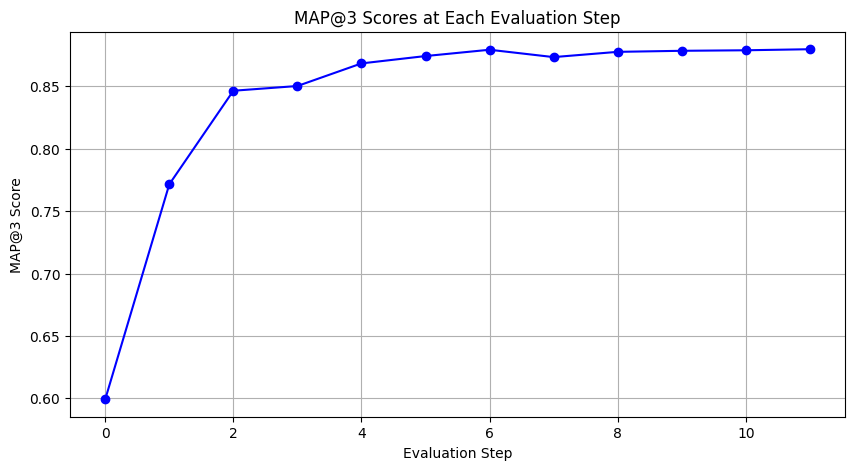

In [27]:
import matplotlib.pyplot as plt
import json

# Load the logs
log_file = f'./checkpoints_{VER}/checkpoint-480/trainer_state.json'
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract MAP@3 scores
map_scores = [log['eval_map@3'] for log in logs['log_history'] if 'eval_map@3' in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(map_scores, marker='o', linestyle='-', color='b')
plt.title('MAP@3 Scores at Each Evaluation Step')
plt.xlabel('Evaluation Step')
plt.ylabel('MAP@3 Score')
plt.grid(True)
plt.show()

In [28]:
df_test['prompt'] = df_test['prompt'].astype(str)
df_test['A'] = df_test['A'].astype(str)
df_test['B'] = df_test['B'].astype(str)
df_test['C'] = df_test['C'].astype(str)
df_test['D'] = df_test['D'].astype(str)

In [29]:
df_test.columns

Index(['id', 'prompt', 'context', 'A', 'B', 'C', 'D', 'answer', 'is_question'], dtype='object')

In [30]:
import numpy as np
import pandas as pd
from datasets import Dataset

test_predictions = trainer.predict(tokenized_dataset_test).predictions

test_predictions = np.array(test_predictions).astype(float)

# print("Sample raw predictions:", test_predictions[:4])

predictions_as_ids = np.argsort(-test_predictions, axis=1)

# print("Sorted prediction indices:", predictions_as_ids[:3])

predictions_as_answer_letters = np.array(list('ABCD'))[predictions_as_ids]


df_test.loc[:, 'prediction'] = [' '.join(row[:3]) for row in predictions_as_answer_letters]

top3_sorted_letters = [''.join(row[:3]) for row in predictions_as_answer_letters]
df_test.loc[:, 'top3_sorted_letters'] = top3_sorted_letters

options_columns = ['A', 'B', 'C', 'D']
top3_text_predictions = []

for i, row in enumerate(predictions_as_ids):
    try:
        top3_text_predictions.append(
            ' '.join([df_test.iloc[i][options_columns[j]] for j in row[:3]])
        )
    except KeyError as e:
        print(f"KeyError for index {i}: {e}")
        top3_text_predictions.append('')

df_test.loc[:, 'top_3_predictions_text'] = top3_text_predictions

test_prediction = df_test[['id', 'prompt', 'context', 'A', 'B', 'C', 'D', 'answer', 'is_question', 'top_3_predictions_text', 'top3_sorted_letters']]

test_prediction

,id,prompt,context,A,B,C,D,answer,is_question,top_3_predictions_text,top3_sorted_letters
393,9-702,An eagle will use their claws to catch which o...,The mountain serpent eagle (Spilornis kinabalu...,nuts and berries,mouse,lion,elephant,B,True,nuts and berries elephant lion,ADC
3467,13-126,Greenhouses are great for plants like,Climate-friendly gardeners will therefore use ...,Pizza,Lollipops,Candles,French beans,D,False,French beans Lollipops Candles,DBC
4918,14-1451,An example of seed dispersal is animals eating...,Seed dispersal via ingestion and defecation by...,dirt,hard shells,grass,animals,B,True,hard shells grass animals,BCD
4308,14-425,Which is least likely to be an ecosystem?,Who will manage which ecosystem? Climate deter...,the plains,the moon base,the desert,the fields,B,True,the desert the moon base the fields,CBD
350,1111,What contains seeds,"Many structures commonly referred to as ""seeds...",human.,whole pumpkin,soda can,leaf,B,False,whole pumpkin human. leaf,BAD
...,...,...,...,...,...,...,...,...,...,...,...
3064,12-782,what do planets orbit?,Bodies that are gravitationally bound to one o...,volcanos,starlight,astral beings,people,C,True,starlight astral beings volcanos,BCA
1583,10-514,The moon is always illustrated in movies and d...,They are the most obvious volcanic features on...,smooth,Earth,rainbow,edible,A,False,smooth Earth rainbow,ABC
4242,14-309,The outer casing of a tree expands how many ti...,A tree in temperate and colder climates typica...,1000 times,ten times,once,100 times,C,False,once 1000 times 100 times,CAD
1569,10-490,The Earth is going to be completing a full rot...,"Earth rotates eastward, in prograde motion. It...",a cloud is going to rain,the moon is in the sky,a day has passed on Jupiter,"the sun rose, set and rose again",D,False,"the sun rose, set and rose again a day has pas...",DCB


In [31]:
def precision_at_k(r, k):
    """Precision at k"""
    assert k <= len(r)
    assert k != 0
    return sum(int(x) for x in r[:k]) / k

def MAP_at_3(predictions, true_items):
    """Score is mean average precision at 3"""
    U = len(predictions)
    map_at_3 = 0.0
    for u in range(U):
        user_preds = predictions[u].split()
        user_true = true_items[u]
        user_results = [1 if item == user_true else 0 for item in user_preds]
        for k in range(min(len(user_preds), 3)):
            map_at_3 += precision_at_k(user_results, k+1) * user_results[k]
    return map_at_3 / U

# Calculate MAP@3
m = MAP_at_3(df_test['prediction'].values, df_test['answer'].values)
print('MAP@3 =', m)

CV MAP@3 = 0.8531879194630869


## Deberta + PEFT  

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

data = pd.read_csv('/kaggle/input/llm-scientific-qa-with-openbook/LLm_Scientific_QA_with_OpenBook.csv')
# data = data.head(100)

df_train, df_temp = train_test_split(data, test_size=0.2, random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.6, random_state=42)

In [29]:
# LENGTH OF CONTEXT PLUS QUESTION ANSWER
MAX_INPUT = 256
# HUGGING FACE MODEL
DEBERTALORAmodel = 'microsoft/deberta-v3-large'

In [30]:
tokenizer = AutoTokenizer.from_pretrained(DEBERTALORAmodel)
model = AutoModelForMultipleChoice.from_pretrained(DEBERTALORAmodel)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForMultipleChoice were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 ### PEFT 

### Interprétation des Paramètres de `LoraConfig`

Voici les détails de chaque paramètre utilisé dans la configuration `LoraConfig` :

1. **task_type (Type de tâche)**:
   - `TaskType.SEQ_2_SEQ_LM`: Spécifie que le modèle est adapté pour des tâches de modélisation de langue séquence à séquence, comme la traduction automatique ou la génération de texte.

2. **inference_mode (Mode d'inférence)**:
   - `False`: Le modèle est en mode d'entraînement. Cela active certaines fonctionnalités spécifiques à l'entraînement, comme l'ajustement des poids via LoRA.

3. **r (Rang)**:
   - `12`: Détermine le rang des matrices LoRA. Un rang de 12 indique des matrices de petite taille relative, permettant une adaptation significative sans réentraînement complet des poids du modèle.

4. **lora_alpha (Facteur de mise à l'échelle LoRA)**:
   - `32`: Contrôle l'impact des matrices LoRA sur les transformations du modèle. Un `lora_alpha` élevé signifie que les adaptations auront un effet plus marqué, modifiant substantiellement les caractéristiques apprises par le modèle.

5. **lora_dropout (Taux de dropout pour LoRA)**:
   - `0.1`: Applique un taux de dropout de 10% aux matrices LoRA, aidant à prévenir le surajustement et à améliorer la généralisation du modèle en mettant aléatoirement à zéro certains éléments durant l'entraînement.


In [19]:
!pip install peft
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.7 MB/s eta 0:00:00:00:01


In [31]:
print('We are using PEFT.')    
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    task_type=TaskType.SEQ_CLS, 
    lora_dropout=0.1, 
    bias="none",
    inference_mode=False, 
    target_modules=["query_proj", "value_proj"],
    modules_to_save=['classifier','pooler'],
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

We are using PEFT.
trainable params: 1,837,057 || all params: 436,899,842 || trainable%: 0.4205


In [41]:
VER=2
# NUMBER OF LAYERS TO FREEZE 
# DEBERTA LARGE HAS TOTAL OF 24 LAYERS
FREEZE_LAYERS = 18
# BOOLEAN TO FREEZE EMBEDDINGS
FREEZE_EMBEDDINGS = True

In [42]:
if FREEZE_EMBEDDINGS:
    print('Freezing embeddings.')
    for param in model.deberta.embeddings.parameters():
        param.requires_grad = False
if FREEZE_LAYERS>0:
    print(f'Freezing {FREEZE_LAYERS} layers.')
    for layer in model.deberta.encoder.layer[:FREEZE_LAYERS]:
        for param in layer.parameters():
            param.requires_grad = False

Freezing embeddings.
Freezing 18 layers.


In [43]:
training_args = TrainingArguments(
    warmup_ratio=0.1,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    report_to='none',  # Vous pouvez définir cela à 'wandb' ou 'tensorboard' pour la visualisation des métriques si nécessaire
    output_dir=f'./checkpoints_{VER}',
    overwrite_output_dir=True,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=40,  # Enregistrer les logs tous les 75 steps
    evaluation_strategy='steps',
    eval_steps=40,  # Évaluer et sauvegarder les métriques tous les 75 steps
    save_strategy="steps",
    save_steps=40,
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin
    metric_for_best_model='map@3',  # Utiliser map@3 pour évaluer le meilleur modèle
    lr_scheduler_type='cosine',
    weight_decay=0.01,
    save_total_limit=1,  # Limiter à une seule sauvegarde
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [46]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_valid,
    compute_metrics = compute_metrics,
)

trainer.train()
trainer.save_model(f'model_v{VER}')

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Map@3
40,1.382400,1.386337,0.474747
80,1.388600,1.386139,0.538300
120,1.380800,1.385715,0.590909
160,1.386600,1.385705,0.607323
200,1.387100,1.385431,0.619949
240,1.391300,1.385239,0.621633
280,1.388500,1.385160,0.620370
320,1.384600,1.384990,0.627525
360,1.389700,1.384869,0.629209
400,1.395800,1.384820,0.625421


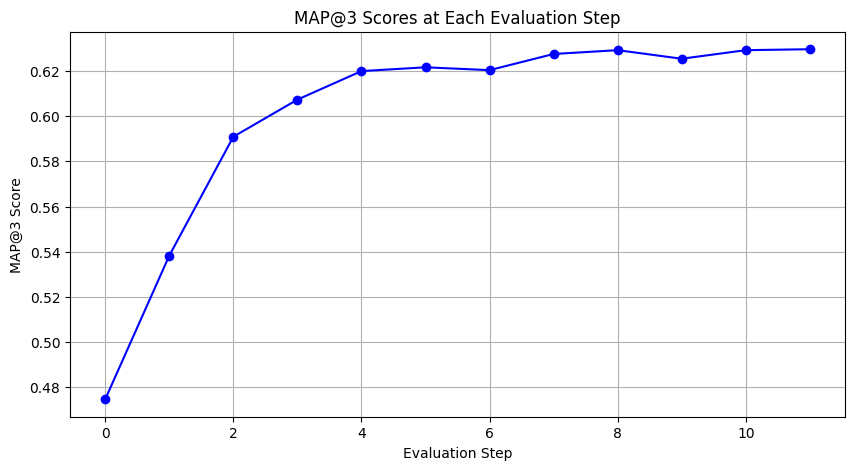

In [48]:
import matplotlib.pyplot as plt
import json

# Load the logs
log_file = f'./checkpoints_{VER}/checkpoint-480/trainer_state.json'
with open(log_file, 'r') as f:
    logs = json.load(f)

# Extract MAP@3 scores
map_scores = [log['eval_map@3'] for log in logs['log_history'] if 'eval_map@3' in log]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(map_scores, marker='o', linestyle='-', color='b')
plt.title('MAP@3 Scores at Each Evaluation Step')
plt.xlabel('Evaluation Step')
plt.ylabel('MAP@3 Score')
plt.grid(True)
plt.show()


In [49]:
df_test['prompt'] = df_test['prompt'].astype(str)
df_test['A'] = df_test['A'].astype(str)
df_test['B'] = df_test['B'].astype(str)
df_test['C'] = df_test['C'].astype(str)
df_test['D'] = df_test['D'].astype(str)

In [50]:
df_test.shape

(596, 9)

In [51]:
tokenized_dataset_test

Dataset({
    features: ['id', 'is_question', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 596
})

In [52]:
import numpy as np
import pandas as pd
from datasets import Dataset

test_predictions = trainer.predict(tokenized_dataset_test).predictions

test_predictions = np.array(test_predictions).astype(float)

# print("Sample raw predictions:", test_predictions[:4])

predictions_as_ids = np.argsort(-test_predictions, axis=1)

# print("Sorted prediction indices:", predictions_as_ids[:3])

predictions_as_answer_letters = np.array(list('ABCD'))[predictions_as_ids]

# print("Sorted prediction letters:", predictions_as_answer_letters[:3])

df_test.loc[:, 'prediction'] = [' '.join(row[:3]) for row in predictions_as_answer_letters]

top3_sorted_letters = [''.join(row[:3]) for row in predictions_as_answer_letters]
df_test.loc[:, 'top3_sorted_letters'] = top3_sorted_letters

options_columns = ['A', 'B', 'C', 'D']
top3_text_predictions = []

for i, row in enumerate(predictions_as_ids):
    try:
        top3_text_predictions.append(
            ' '.join([df_test.iloc[i][options_columns[j]] for j in row[:3]])
        )
    except KeyError as e:
        print(f"KeyError for index {i}: {e}")
        top3_text_predictions.append('')

df_test.loc[:, 'top_3_predictions_text'] = top3_text_predictions

test_prediction = df_test[['id', 'prompt', 'context', 'A', 'B', 'C', 'D', 'answer', 'is_question', 'top_3_predictions_text', 'top3_sorted_letters']]

test_prediction

,id,prompt,context,A,B,C,D,answer,is_question,top_3_predictions_text,top3_sorted_letters
393,9-702,An eagle will use their claws to catch which o...,The mountain serpent eagle (Spilornis kinabalu...,nuts and berries,mouse,lion,elephant,B,True,nuts and berries elephant lion,ADC
3467,13-126,Greenhouses are great for plants like,Climate-friendly gardeners will therefore use ...,Pizza,Lollipops,Candles,French beans,D,False,French beans Lollipops Candles,DBC
4918,14-1451,An example of seed dispersal is animals eating...,Seed dispersal via ingestion and defecation by...,dirt,hard shells,grass,animals,B,True,hard shells grass animals,BCD
4308,14-425,Which is least likely to be an ecosystem?,Who will manage which ecosystem? Climate deter...,the plains,the moon base,the desert,the fields,B,True,the moon base the desert the plains,BCA
350,1111,What contains seeds,"Many structures commonly referred to as ""seeds...",human.,whole pumpkin,soda can,leaf,B,False,human. whole pumpkin soda can,ABC
...,...,...,...,...,...,...,...,...,...,...,...
3064,12-782,what do planets orbit?,Bodies that are gravitationally bound to one o...,volcanos,starlight,astral beings,people,C,True,astral beings volcanos starlight,CAB
1583,10-514,The moon is always illustrated in movies and d...,They are the most obvious volcanic features on...,smooth,Earth,rainbow,edible,A,False,smooth edible rainbow,ADC
4242,14-309,The outer casing of a tree expands how many ti...,A tree in temperate and colder climates typica...,1000 times,ten times,once,100 times,C,False,ten times 1000 times 100 times,BAD
1569,10-490,The Earth is going to be completing a full rot...,"Earth rotates eastward, in prograde motion. It...",a cloud is going to rain,the moon is in the sky,a day has passed on Jupiter,"the sun rose, set and rose again",D,False,a cloud is going to rain a day has passed on J...,ACB


In [58]:
def precision_at_k(r, k):
    """Precision at k"""
    assert k <= len(r)
    assert k != 0
    return sum(int(x) for x in r[:k]) / k

def MAP_at_3(predictions, true_items):
    """Score is mean average precision at 3"""
    U = len(predictions)
    map_at_3 = 0.0
    for u in range(U):
        user_preds = predictions[u].split()
        user_true = true_items[u]
        user_results = [1 if item == user_true else 0 for item in user_preds]
        for k in range(min(len(user_preds), 3)):
            map_at_3 += precision_at_k(user_results, k+1) * user_results[k]
    return map_at_3 / U

# Calculate MAP@3
m = MAP_at_3(df_test['prediction'].values, df_test['answer'].values)
print('CV MAP@3 =', m)

CV MAP@3 = 0.6065436241610733


# Phi-3

In [1]:
from datasets import Dataset, load_metric
import pandas as pd
import numpy as np
import torch
from dataclasses import dataclass
from transformers import AutoTokenizer, PreTrainedTokenizerBase
from transformers.tokenization_utils_base import PaddingStrategy
from typing import Optional, Union

import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

data = pd.read_csv('/kaggle/input/llm-scientific-qa-with-openbook/LLm_Scientific_QA_with_OpenBook.csv')
# data = data.head(100)

df_train, df_temp = train_test_split(data, test_size=0.2, random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.6, random_state=42)

In [3]:
for i in df_train.columns:
    print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [10]:
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM


# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")
MAX_INPUT = 256  # Set the maximum length of the tokenizer

# Mapping the answer choices to integers
option_to_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

def preprocess(examples):
    # Extracting all fields
    contexts = examples['context']
    prompts = examples['prompt']
    answers = [option_to_index[i] for i in examples['answer']]
    
    # Tokenization
    encoding = tokenizer(
        text=[f"[CLS] {context} [SEP] {prompt} Option A: {examples['A'][i]} Option B: {examples['B'][i]} Option C: {examples['C'][i]} Option D: {examples['D'][i]}" for i, (context, prompt) in enumerate(zip(contexts, prompts))],
        add_special_tokens=False,
        truncation=True,
        max_length=MAX_INPUT,
        padding="max_length",
        return_tensors="pt"
    )

    # Add labels
    encoding['labels'] = torch.tensor(answers)

    return encoding

# Applying preprocessing and creating datasets
train_dataset = Dataset.from_pandas(df_train).map(preprocess, batched=True)
valid_dataset = Dataset.from_pandas(df_valid).map(preprocess, batched=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3965 [00:00<?, ? examples/s]

Map:   0%|          | 0/396 [00:00<?, ? examples/s]

In [5]:
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    report_to='none',  # Vous pouvez définir cela à 'wandb' ou 'tensorboard' pour la visualisation des métriques si nécessaire
    output_dir="./phi3_finetuned",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

2024-06-27 12:37:59.424543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 12:37:59.424669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 12:37:59.562028: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Define a simple example metric for demonstration
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = (predictions == labels).float().mean()
    return {'accuracy': accuracy}

In [11]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

config.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 376.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 347.06 MiB is free. Process 3182 has 14.41 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 1.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## llama

In [82]:
LLAMAmodel = 'meta-llama/Meta-Llama-3-8B'

In [83]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Charger le tokenizer et le modèle depuis le hub de Hugging Face
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:769: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:468: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [86]:
from bitsandbytes.optim import Adam8bit

optimizer = Adam8bit(model.parameters(), lr=2e-5)

In [100]:
print('We are using PEFT.')    
peft_config = LoraConfig(
    r=5,
    lora_alpha=5,
    task_type=TaskType.SEQ_CLS, 
    lora_dropout=0.1, 
    bias="none",
    inference_mode=False, 
#     target_modules=["query_proj", "value_proj"],
    modules_to_save=['classifier','pooler'],
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

We are using PEFT.
trainable params: 2,621,440 || all params: 6,741,037,056 || trainable%: 0.0389


In [101]:
# VER=1
# # NUMBER OF LAYERS TO FREEZE 
# # DEBERTA LARGE HAS TOTAL OF 24 LAYERS
# FREEZE_LAYERS = 18
# # BOOLEAN TO FREEZE EMBEDDINGS
# FREEZE_EMBEDDINGS = True

In [102]:
# if FREEZE_EMBEDDINGS:
#     print('Freezing embeddings.')
#     for param in model.deberta.embeddings.parameters():
#         param.requires_grad = False
# if FREEZE_LAYERS>0:
#     print(f'Freezing {FREEZE_LAYERS} layers.')
#     for layer in model.deberta.encoder.layer[:FREEZE_LAYERS]:
#         for param in layer.parameters():
#             param.requires_grad = False

In [103]:
training_args = TrainingArguments(
    warmup_ratio=0.1,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=1,
    report_to='none',  # Vous pouvez définir cela à 'wandb' ou 'tensorboard' pour la visualisation des métriques si nécessaire
    output_dir=f'./llmcheckpoints_{VER}',
    overwrite_output_dir=True,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=40,  # Enregistrer les logs tous les 75 steps
    evaluation_strategy='steps',
    eval_steps=40,  # Évaluer et sauvegarder les métriques tous les 75 steps
    save_strategy="steps",
    save_steps=40,
    load_best_model_at_end=True,  # Charger le meilleur modèle à la fin
    metric_for_best_model='map@3',  # Utiliser map@3 pour évaluer le meilleur modèle
    lr_scheduler_type='cosine',
    weight_decay=0.01,
    save_total_limit=1,  # Limiter à une seule sauvegarde
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [111]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_valid,
    compute_metrics = compute_metrics,
)

trainer.train()
trainer.save_model(f'model_v{VER}')

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 62.12 MiB is free. Process 3193 has 15.83 GiB memory in use. Of the allocated memory 15.09 GiB is allocated by PyTorch, and 450.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# T5 + Custom probability method

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

data = pd.read_csv('/kaggle/input/llm-scientific-qa-with-openbook/LLm_Scientific_QA_with_OpenBook.csv')
# data = data.head(100)

df_train, df_temp = train_test_split(data, test_size=0.2, random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.6, random_state=42)

In [8]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset, load_dataset
from dataclasses import dataclass
from torch.utils.data import DataLoader

# Define a custom dataset class for handling QA datasets
class QADataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        prompt = row['prompt']
        context = row['context']
        options = [row['A'], row['B'], row['C'], row['D']]
        input_text = f"question: {prompt} context: {context} options: A: {options[0]} B: {options[1]} C: {options[2]} D: {options[3]}"
        inputs = self.tokenizer(input_text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_len)
        labels = self.tokenizer(row['answer'], return_tensors="pt", max_length=30).input_ids.squeeze()
        return {
            "input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": labels,
            "options": options,
            "correct_answer": row['answer']
        }

    def __len__(self):
        return len(self.dataframe)

# Initialize tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare datasets
train_dataset = QADataset(df_train, tokenizer)
val_dataset = QADataset(df_valid, tokenizer)
test_dataset = QADataset(df_test, tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=500,
    lr_scheduler_type='cosine',
    weight_decay=0.01,
    logging_dir='./logs',
    overwrite_output_dir=True,
    fp16=True,
    gradient_accumulation_steps=4,
    logging_steps=40,  # Enregistrer les logs tous les 75 steps
    evaluation_strategy='steps',
    eval_steps=40,  # Évaluer et sauvegarder les métriques tous les 75 steps
    save_strategy="steps",
    save_steps=40,
    load_best_model_at_end=True,
    report_to='none'
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Step,Training Loss,Validation Loss
40,6.782000,6.967553
80,6.037800,5.373116
120,4.113900,3.454006
160,2.708200,2.180580
200,1.702500,1.217952
240,1.017300,0.853602
280,0.850200,0.778206
320,0.802600,0.761175
360,0.785700,0.750006
400,0.768900,0.733048


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=495, training_loss=2.2112496424202965, metrics={'train_runtime': 470.9465, 'train_samples_per_second': 8.419, 'train_steps_per_second': 1.051, 'total_flos': 535953533829120.0, 'train_loss': 2.2112496424202965, 'epoch': 0.9984871406959153})

In [10]:
# print(model)

In [11]:
def compute_option_probabilities(model, tokenizer, question, context, options, device):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    option_scores = []
    for option in options:
        option_input = tokenizer(option, return_tensors="pt", padding=True, truncation=True, max_length=30).input_ids.to(device)
        output = model(**inputs, labels=option_input)
        log_likelihood = -output.loss.item()
        option_scores.append(log_likelihood)
    
    # Convert log-likelihoods to probabilities
    probabilities = torch.nn.functional.softmax(torch.tensor(option_scores), dim=0).tolist()
    return probabilities

In [13]:
def format_and_rank_options(options, probabilities):
    ranked_options = [f"{chr(65 + i)}: {prob:.2f}" for i, prob in enumerate(probabilities)]
    sorted_ranked_options = sorted(ranked_options, key=lambda x: float(x.split(': ')[1]), reverse=True)
    return sorted_ranked_options[:4]  

def get_ranked_letters(probabilities):
    ranked_indices = sorted(range(len(probabilities)), key=lambda i: probabilities[i], reverse=True)[:4]
    ranked_letters = ''.join([chr(65 + i) for i in ranked_indices])
    return ranked_letters

In [14]:
# Ajout des colonnes 'sorted' et 'ranked_letters' au DataFrame
def add_columns(df, model, tokenizer, device):
    sorted_answers = []
    ranked_letters = []
    for index, row in df.iterrows():
        question = row['prompt']
        context = row['context']
        options = [row['A'], row['B'], row['C'], row['D']]
        probabilities = compute_option_probabilities(model, tokenizer, question, context, options, device)
        ranked_options = format_and_rank_options(options, probabilities)
        sorted_answers.append(ranked_options)
        ranked_letters.append(get_ranked_letters(probabilities))
    df['sorted'] = sorted_answers
    df['ranked_letters'] = ranked_letters
    return df

# Application de la fonction à df_test
df_test = add_columns(df_test, model, tokenizer, device)
df_test

,id,prompt,context,A,B,C,D,answer,is_question,sorted,ranked_letters
393,9-702,An eagle will use their claws to catch which o...,The mountain serpent eagle (Spilornis kinabalu...,nuts and berries,mouse,lion,elephant,B,True,"[C: 0.90, A: 0.04, B: 0.04, D: 0.02]",CBAD
3467,13-126,Greenhouses are great for plants like,Climate-friendly gardeners will therefore use ...,Pizza,Lollipops,Candles,French beans,D,False,"[C: 0.90, B: 0.09, A: 0.01, D: 0.00]",CBAD
4918,14-1451,An example of seed dispersal is animals eating...,Seed dispersal via ingestion and defecation by...,dirt,hard shells,grass,animals,B,True,"[D: 0.71, C: 0.21, A: 0.06, B: 0.02]",DCAB
4308,14-425,Which is least likely to be an ecosystem?,Who will manage which ecosystem? Climate deter...,the plains,the moon base,the desert,the fields,B,True,"[A: 0.79, D: 0.13, C: 0.06, B: 0.02]",ADCB
350,1111,What contains seeds,"Many structures commonly referred to as ""seeds...",human.,whole pumpkin,soda can,leaf,B,False,"[A: 0.44, D: 0.40, C: 0.13, B: 0.04]",ADCB
...,...,...,...,...,...,...,...,...,...,...,...
3064,12-782,what do planets orbit?,Bodies that are gravitationally bound to one o...,volcanos,starlight,astral beings,people,C,True,"[D: 0.77, A: 0.20, B: 0.03, C: 0.00]",DABC
1583,10-514,The moon is always illustrated in movies and d...,They are the most obvious volcanic features on...,smooth,Earth,rainbow,edible,A,False,"[B: 0.94, A: 0.03, D: 0.02, C: 0.01]",BADC
4242,14-309,The outer casing of a tree expands how many ti...,A tree in temperate and colder climates typica...,1000 times,ten times,once,100 times,C,False,"[C: 0.67, B: 0.21, A: 0.09, D: 0.02]",CBAD
1569,10-490,The Earth is going to be completing a full rot...,"Earth rotates eastward, in prograde motion. It...",a cloud is going to rain,the moon is in the sky,a day has passed on Jupiter,"the sun rose, set and rose again",D,False,"[B: 0.66, C: 0.21, A: 0.10, D: 0.02]",BCAD


In [15]:
df_test.columns

Index(['id', 'prompt', 'context', 'A', 'B', 'C', 'D', 'answer', 'is_question',
       'sorted', 'ranked_letters'],
      dtype='object')

In [17]:
# Fonctions de calcul des métriques
def precision_at_k(r, k):
    """Precision at k"""
    assert k <= len(r)
    assert k != 0
    return sum(int(x) for x in r[:k]) / k

def MAP_at_3(predictions, true_items):
    """Score is mean average precision at 3"""
    U = len(predictions)
    map_at_3 = 0.0
    for u in range(U):
        user_preds = predictions[u]  # No split needed, already a list
        user_true = true_items[u]
        user_results = [1 if item == user_true else 0 for item in user_preds]
        for k in range(min(len(user_preds), 4)):
            map_at_3 += precision_at_k(user_results, k+1) * user_results[k]
    return map_at_3 / U

# Exemple de données préparées
# La colonne 'ranked_letters' devrait ressembler à ['BAC', 'ACB', etc.]
# 'answer' est une colonne avec la réponse correcte, par exemple 'B'

# Transformation des lettres en liste de caractères
df_test['prediction'] = df_test['ranked_letters'].apply(lambda x: list(x))

# Calcul de la métrique MAP@3
m = MAP_at_3(df_test['prediction'].values, df_test['answer'].values)
print('CV MAP@3 =', m)

CV MAP@3 = 0.5230704697986577
